# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import pytz
import datetime 
import cPickle as pickle
import astral
import astropy.time as aptime
from scipy import stats
from scipy import interpolate
from scipy import optimize
import os
import time
from matplotlib import gridspec

In [14]:
from matplotlib import rc
from matplotlib import rcParams
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('axes', labelsize=20) 
rc('axes', linewidth=2)

rcParams['axes.titlesize'] = 25
rcParams['legend.fontsize'] = 20
rcParams['patch.linewidth'] = 1
rcParams['axes.titlepad'] = 30

In [2]:
pkl_file = open("GS-env-2014-19_p2.pkl", 'rb')
dictionary = pickle.load(pkl_file)
pkl_file.close()
dictionary_copy = copy.copy(dictionary)

# Merge sensors

In [3]:
env_data = dictionary_copy

sensor_list = ['T_M1+Y','T_M1-Y','T_TrussAirLow+X','T_TrussAirMid+X','T_TrussAirTop+X',
               'T_TrussSurLow+X','T_TrussSurMid+X','T_TrussSurTop+X','T_twr']

n=0
for sensor in sensor_list:
    
    #  convert list to arrays and make an MJDOBS column
    env_data[sensor]['vals'] = np.array(env_data[sensor]['vals'])
    env_data[sensor]['dts'] = np.array(env_data[sensor]['dts'])
    env_data[sensor]['MJDOBS'] = aptime.Time(env_data[sensor]['dts'], format='datetime').mjd
    
    #  Get rid of zeros and outliers 
    cond1 = env_data[sensor]['vals'] != 0.
    cond2 = np.abs(env_data[sensor]['vals']) < 20.
    
    ind = np.where(cond1 & cond2)[0]
    
    env_data[sensor]['vals'] = env_data[sensor]['vals'][ind]
    env_data[sensor]['dts'] = env_data[sensor]['dts'][ind]
    env_data[sensor]['MJDOBS'] = env_data[sensor]['MJDOBS'][ind]
    
    #  merge other sensor data columns to M1+Y data table
    if n==0:
        df = pd.DataFrame(columns = ['dts','MJDOBS',sensor])
        df[sensor] = pd.Series(env_data[sensor]['vals'])
        df['dts'] = pd.Series(env_data[sensor]['dts'])
        df['MJDOBS'] = pd.Series(env_data[sensor]['MJDOBS'])
        df = df.sort_values(by = ['dts'])
        n=1
   
    else:
        newdf = pd.DataFrame(columns = [sensor,'dts'])
        newdf[sensor] = pd.Series(env_data[sensor]['vals'])
        newdf['dts'] = pd.Series(env_data[sensor]['dts'])
        newdf = newdf.sort_values(by = ['dts'])
        
        df = pd.merge_asof(df,newdf, on='dts',tolerance=pd.Timedelta('30min')) #before it was 30min
        
env_data = df
env_data['dts'] = env_data['dts'].dt.tz_localize(pytz.UTC)

date upper limit 

In [50]:
env_data.keys()

Index([u'dts', u'MJDOBS', u'T_M1+Y', u'T_M1-Y', u'T_TrussAirLow+X',
       u'T_TrussAirMid+X', u'T_TrussAirTop+X', u'T_TrussSurLow+X',
       u'T_TrussSurMid+X', u'T_TrussSurTop+X', u'T_twr'],
      dtype='object')

In [37]:
print len(env_data)
for sensor in sensor_list:
    print sum(~np.isfinite(env_data[sensor]))  

330426
0
270
123
139
537
5376
27
1573
539


date lower bound 

In [6]:
%matplotlib notebook

date = datetime.date(year = 2017, month = 8, day =3) #calibration date 
ind1 = np.where(env_data['dts'] == date)[0]
ind2 = np.where(env_data['dts'] > date)[0]

Checking right at the change date  

<IPython.core.display.Javascript object>


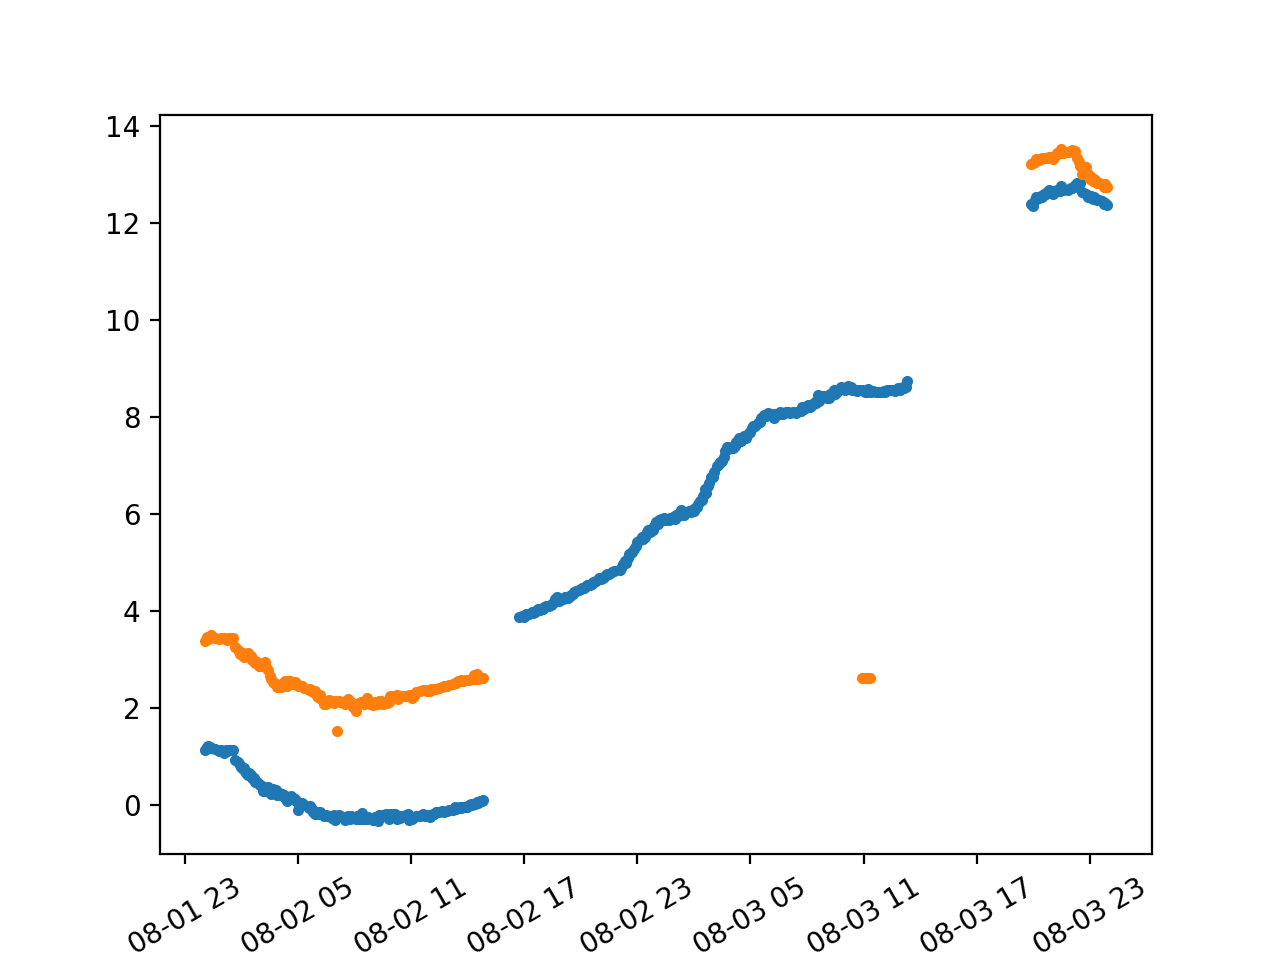

(array([ 736542.95833333,  736543.20833333,  736543.45833333,
         736543.70833333,  736543.95833333,  736544.20833333,
         736544.45833333,  736544.70833333,  736544.95833333]),
 <a list of 9 Text xticklabel objects>)

In [68]:
%matplotlib notebook

date1 = datetime.datetime(year = 2017, month = 8, day =2)
date2 = datetime.datetime(year = 2017, month = 8, day =4)

cond1 = env_data['dts'] >= date1
cond2  = env_data['dts'] <= date2

ind = np.where(cond1 & cond2)[0]

cp = env_data.iloc[ind]

plt.plot(cp['dts'],cp['T_M1+Y'],'.')
plt.plot(cp['dts'],cp['T_M1-Y'],'.')
plt.xticks(rotation=30)

In [118]:
#print af.loc[0,'T_M1+Y']
print bf.loc[len(bf)-1,'T_M1+Y'] 

#print af.loc[0,'T_M1-Y']
print bf.loc[len(bf)-1,'T_M1-Y'] 

#print af.loc[0,'dts']
print bf.loc[len(bf)-1,'dts'] 

0.09
2.62
2017-08-02 14:49:18.360988+00:00


# Calculating measurement offsets

There is seasonal variation in each sensor so we will fold them over and subtract the last six months of data

In [11]:
''' plt.figure(1,figsize=[8,6])
    plt.plot(x,y,'.',color='silver',markersize=3)
    plt.plot(x2,y2,'.',color='b',markersize=3)
    plt.plot(x,func(x,*popt),'r',lw=3)
    plt.xticks([])
    plt.xlabel('Time')
    plt.ylabel('M+Y Temperature [$C^\circ$]')
    #plt.legend(['BF cal','AF cal', 'BF cal fit'],fontsize=15)
    plt.tick_params(axis='both',which = 'both',direction='in', width=2,length = 7, bottom = False, top=True,)
    plt.show()
    
    plt.savefig('/Users/melisaT/Dropbox (GPI)/TEST_SCRATCH/scratch/mtallis/plots/SPIE_poster_figs/cal_fit.png')'''


" plt.figure(1,figsize=[8,6])\n    plt.plot(x,y,'.',color='silver',markersize=3)\n    plt.plot(x2,y2,'.',color='b',markersize=3)\n    plt.plot(x,func(x,*popt),'r',lw=3)\n    plt.xticks([])\n    plt.xlabel('Time')\n    plt.ylabel('M+Y Temperature [$C^\\circ$]')\n    #plt.legend(['BF cal','AF cal', 'BF cal fit'],fontsize=15)\n    plt.tick_params(axis='both',which = 'both',direction='in', width=2,length = 7, bottom = False, top=True,)\n    plt.show()\n    \n    plt.savefig('/Users/melisaT/Dropbox (GPI)/TEST_SCRATCH/scratch/mtallis/plots/SPIE_poster_figs/cal_fit.png')"

ERROR! Session/line number was not unique in database. History logging moved to new session 1124


# All years combined 

In [9]:
def find_offset_yrs_combined(sensor):
    
    #  Split data into before and after calibration data frames. 
    date = datetime.date(year = 2017, month = 8, day =2)
    ind1 = np.where(env_data['dts'] <= date)[0]
    ind2 = np.where(env_data['dts'] > date)[0]

    bf = env_data.iloc[ind1].sort_values(by='dts').set_index(np.arange(len(ind1)))
    af = env_data.iloc[ind2].sort_values(by = 'dts').set_index(np.arange(len(ind2)))
    
    #  Replace year of dts to 2000
    bf.loc[:,'dts'] = bf['dts'].apply(lambda dt: dt.replace(year = 2000 )) 
    bf.loc[:,'MJDOBS'] = aptime.Time(bf['dts'].dt.to_pydatetime(), format='datetime').mjd  # Calculate MJD date after changing year 
    bf = bf.sort_values(by ='dts').set_index(np.arange(len(bf))).dropna(subset=[sensor])  #  Sort the values in order by date

    af.loc[:,'dts'] = af['dts'].apply(lambda dt: dt.replace(year = 2000 ))
    af.loc[:,'MJDOBS'] = aptime.Time(af['dts'].dt.to_pydatetime(), format='datetime').mjd
    af = af.sort_values(by ='dts').set_index(np.arange(len(af))).dropna(subset=[sensor])
    
    
    #  function that fits a curve to data before calibration   
    def func(x, a, b):
        return a*x + b
    
    #date = datetime.date(year = 2000, month = 8, day =2)
    date = datetime.date(year = 2000, month = 7, day =1)


    ind = np.where(bf['dts'] < date)[0]

    bf.loc[:,'dts'] = bf['dts'].apply(lambda dt: dt.replace(year = 2000 ))  #  Replace year of dts to 2000
    bf.loc[:,'MJDOBS'] = aptime.Time(bf['dts'].dt.to_pydatetime(), format='datetime').mjd  # Calculate MJD date after changing year 
    bf = bf.sort_values(by ='dts').set_index(np.arange(len(bf))).dropna(subset=[sensor])  #  Sort the values in order by date

    af.loc[:,'dts'] = af['dts'].apply(lambda dt: dt.replace(year = 2000 ))
    af.loc[:,'MJDOBS'] = aptime.Time(af['dts'].dt.to_pydatetime(), format='datetime').mjd
    af = af.sort_values(by ='dts').set_index(np.arange(len(af))).dropna(subset=[sensor])
    

#  Input arrays for curve fit
    x = bf.loc[ind,'MJDOBS']
    y = bf.loc[ind,sensor]
    
    x2 = af['MJDOBS']
    y2 = af[sensor]
     
    #  model calibration model
    popt,pcov = optimize.curve_fit(func,x,y)
    
    # minimize the error between the post calibration and the fit model of before calibration
    def J(offset):
        x = af['MJDOBS']  #  dates for fit
        y = af[sensor]  # temp post calibration 
        m = func(x, *popt) # fit of pre-calibrated temp
        return np.sum((y[None,:] - m[None,:] + offset[:,None])**2,axis=1) 

    l = np.linspace(-10,10,2000)
    Jarr = J(l)
    idx = np.argmin(Jarr) 
    return l[idx]    

In [10]:
find_offset_yrs_combined('T_M1-Y')

-9.5097548774387199

# One year at a time

In [65]:
def find_offset(sensor,yr):
    
    if yr > 2016:
        print('Data have already been recalibrated in 02/03/2017 so theoretically values shouls be accurate')
    
#  Split data into before and after calibration data frames. 
    date = datetime.date(year = 2017, month = 8, day =2) # last day before calibration
    ind1 = np.where(env_data['dts'] <= date)[0]
    ind2 = np.where(env_data['dts'] > date)[0]

    bf = env_data.iloc[ind1].sort_values(by='dts').set_index(np.arange(len(ind1)))
    af = env_data.iloc[ind2].sort_values(by = 'dts').set_index(np.arange(len(ind2)))
    
    # pick all points in specified year
    bf_date1 = datetime.datetime(year = yr, month = 1, day =1) # lower bound of data beofre calibration
    bf_date2 = datetime.datetime(year = yr, month = 12, day = 31)

    cond1 = bf['dts'] > bf_date1
    cond2  = bf['dts'] <= bf_date2
    bf_ind = np.where(cond1 & cond2)[0]
        
    bf = bf.iloc[bf_ind].sort_values(by='dts').set_index(np.arange(len(bf_ind))).dropna(subset=[sensor])
    
    #  Replace year of after to coincide with year of before
    af.loc[:,'dts'] = af['dts'].apply(lambda dt: dt.replace(year = yr))
    af.loc[:,'MJDOBS'] = aptime.Time(af['dts'].dt.to_pydatetime(), format='datetime').mjd
    af = af.sort_values(by ='dts').set_index(np.arange(len(af))).dropna(subset=[sensor])
    
    #  function that fits a curve to data before calibration   
    def func(x, a, b):
        return a*x + b

#  Input arrays for curve fit
    x = bf['MJDOBS']
    y = bf[sensor]
    
    x2 = af['MJDOBS']
    y2 = af[sensor]
     
    #  model calibration model
    popt,pcov = optimize.curve_fit(func,x,y)
    
    # minimize the error between the post calibration and the fit model of before calibration
    def J(offset):
        x = af['MJDOBS']  #  dates for fit
        y = af[sensor]  # temp post calibration 
        m = func(x, *popt) # fit of pre-calibrated temp
        return np.sum((y[None,:] - m[None,:] + offset[:,None])**2,axis=1) 

    l = np.linspace(-10,10,2000)
    Jarr = J(l)
    idx = np.argmin(Jarr) 
    return l[idx]    

In [67]:
find_offset('T_M1+Y',2016)

-3.9169584792396197

# Summary of Results

Make an empty dataframe that will store values

In [73]:
yr_list = [2014,2015,2016]
offset_summary = pd.DataFrame(columns=yr_list,index=sensor_list)
offset_summary['combined'] = np.nan

Fill values of dataframe

In [74]:
for s in sensor_list:
    print s 
    offset_summary.loc[s,'combined'] = find_offset_yrs_combined(s)
    for yr in yr_list:
        print yr
        offset_summary.loc[s,yr] = find_offset(s,yr)

T_M1+Y
2014
2015
2016
T_M1-Y
2014
2015
2016
T_TrussAirLow+X
2014
2015
2016
T_TrussAirMid+X
2014
2015
2016
T_TrussAirTop+X
2014
2015
2016
T_TrussSurLow+X
2014
2015
2016
T_TrussSurMid+X
2014
2015
2016
T_TrussSurTop+X
2014
2015
2016
T_twr
2014
2015
2016


In [106]:
print(offset_summary)

                      2014      2015      2016  combined
T_M1+Y            -4.85743  -5.31766  -3.91696 -4.667334
T_M1-Y            -3.23662  -3.51676  -1.86593 -2.856428
T_TrussAirLow+X   -1.51576  -2.08604 -0.555278 -1.335668
T_TrussAirMid+X  -0.615308  -1.11556  0.375188 -0.405203
T_TrussAirTop+X  -0.485243  -1.07554  0.345173 -0.325163
T_TrussSurLow+X  -0.615308  -1.09555  0.445223 -0.345173
T_TrussSurMid+X   -1.03552  -1.48574  0.295148 -0.655328
T_TrussSurTop+X  -0.445223   -1.0055  0.345173 -0.305153
T_twr            0.0150075 -0.825413  0.135068 -0.265133


In [103]:
offset_summary.loc[:,[2014,2015,2016]].mean(axis=1)

T_M1+Y            -4.697349
T_M1-Y            -2.873103
T_TrussAirLow+X   -1.385693
T_TrussAirMid+X   -0.451893
T_TrussAirTop+X   -0.405203
T_TrussSurLow+X   -0.421878
T_TrussSurMid+X   -0.742038
T_TrussSurTop+X   -0.368518
T_twr             -0.225113
dtype: float64

In [104]:
offset_summary.loc[:,[2014,2015,2016]].std(axis=1)

T_M1+Y             0.713939
T_M1-Y             0.883410
T_TrussAirLow+X    0.773627
T_TrussAirMid+X    0.758689
T_TrussAirTop+X    0.713729
T_TrussSurLow+X    0.788387
T_TrussSurMid+X    0.926008
T_TrussSurTop+X    0.678597
T_twr              0.523330
dtype: float64

# Figures

Apply sensor offsets and calculate difference across primary mirror. 

In [5]:
cp = copy.deepcopy(env_data)

/Users/MelisaT/anaconda/envs/python2/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<IPython.core.display.Javascript object>


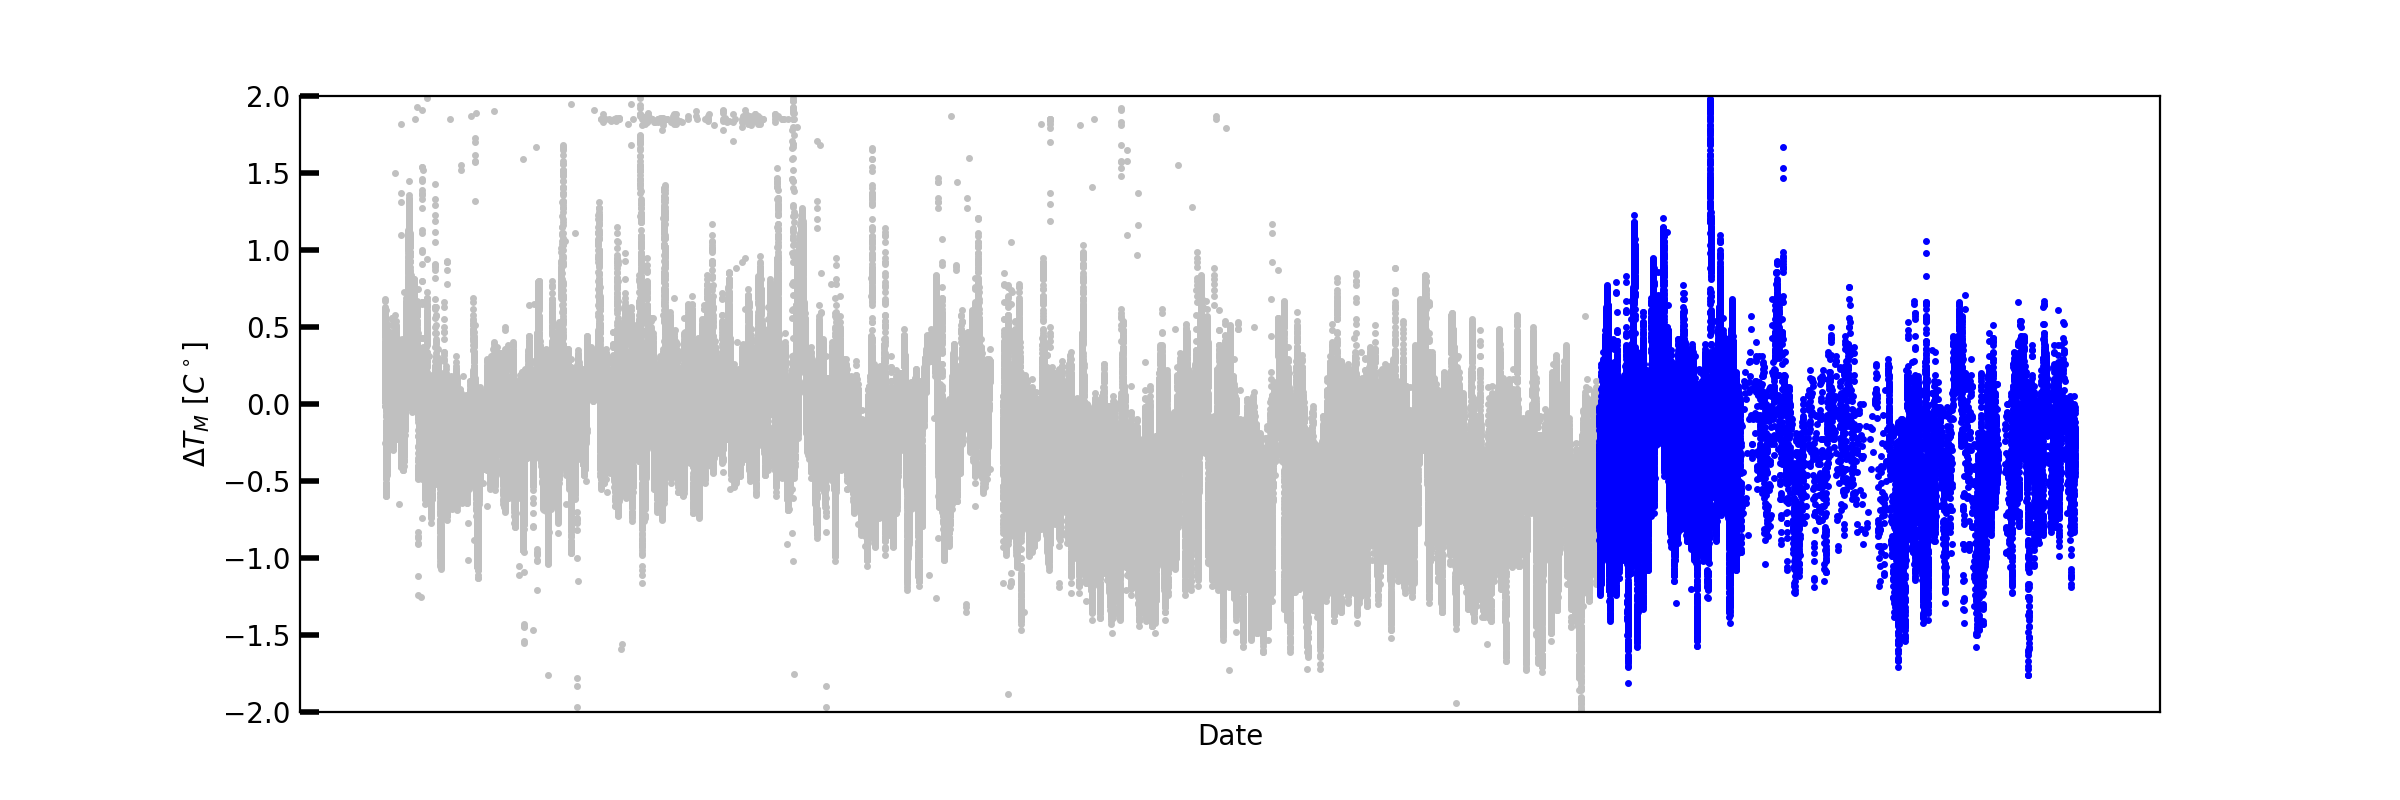

([], <a list of 0 Text xticklabel objects>)

In [70]:
%matplotlib notebook

date = datetime.date(year = 2017, month = 8, day =3)

#  AO system requirements
cond1 = (env_data['dts'] > date) 
ind = np.where(cond1)[0]

cond2 = (env_data['dts'] < date) 
ind2 = np.where(cond2)[0]

af = cp.iloc[ind]
bf = cp.iloc[ind2]

bf.loc[ind2,'T_M1+Y'] = bf.loc[ind2,'T_M1+Y'] + 4.16
bf.loc[ind2,'T_M1-Y'] = bf.loc[ind2,'T_M1-Y'] + 2.31

fig = plt.figure(figsize=[12,4])
plt.plot(bf['dts'],bf['T_M1+Y']-bf['T_M1-Y'],'.',markersize = 3,color='silver')
plt.plot(af['dts'],af['T_M1+Y']-af['T_M1-Y'],'.',markersize = 3,color='b')
plt.ylim(-2,2)
plt.xlabel('Date')
plt.ylabel(r'$\Delta{T}_{M}$ [$C^\circ$]')

plt.tick_params(axis='both',which = 'both',direction='in', width=2,length = 7)
plt.xticks([])

#plt.savefig('/Users/melisa/Dropbox (GPI)/TEST_SCRATCH/scratch/mtallis/plots/SPIE_poster_figs/post_calibration.png')


Show seasonal variation and results of operation

<IPython.core.display.Javascript object>


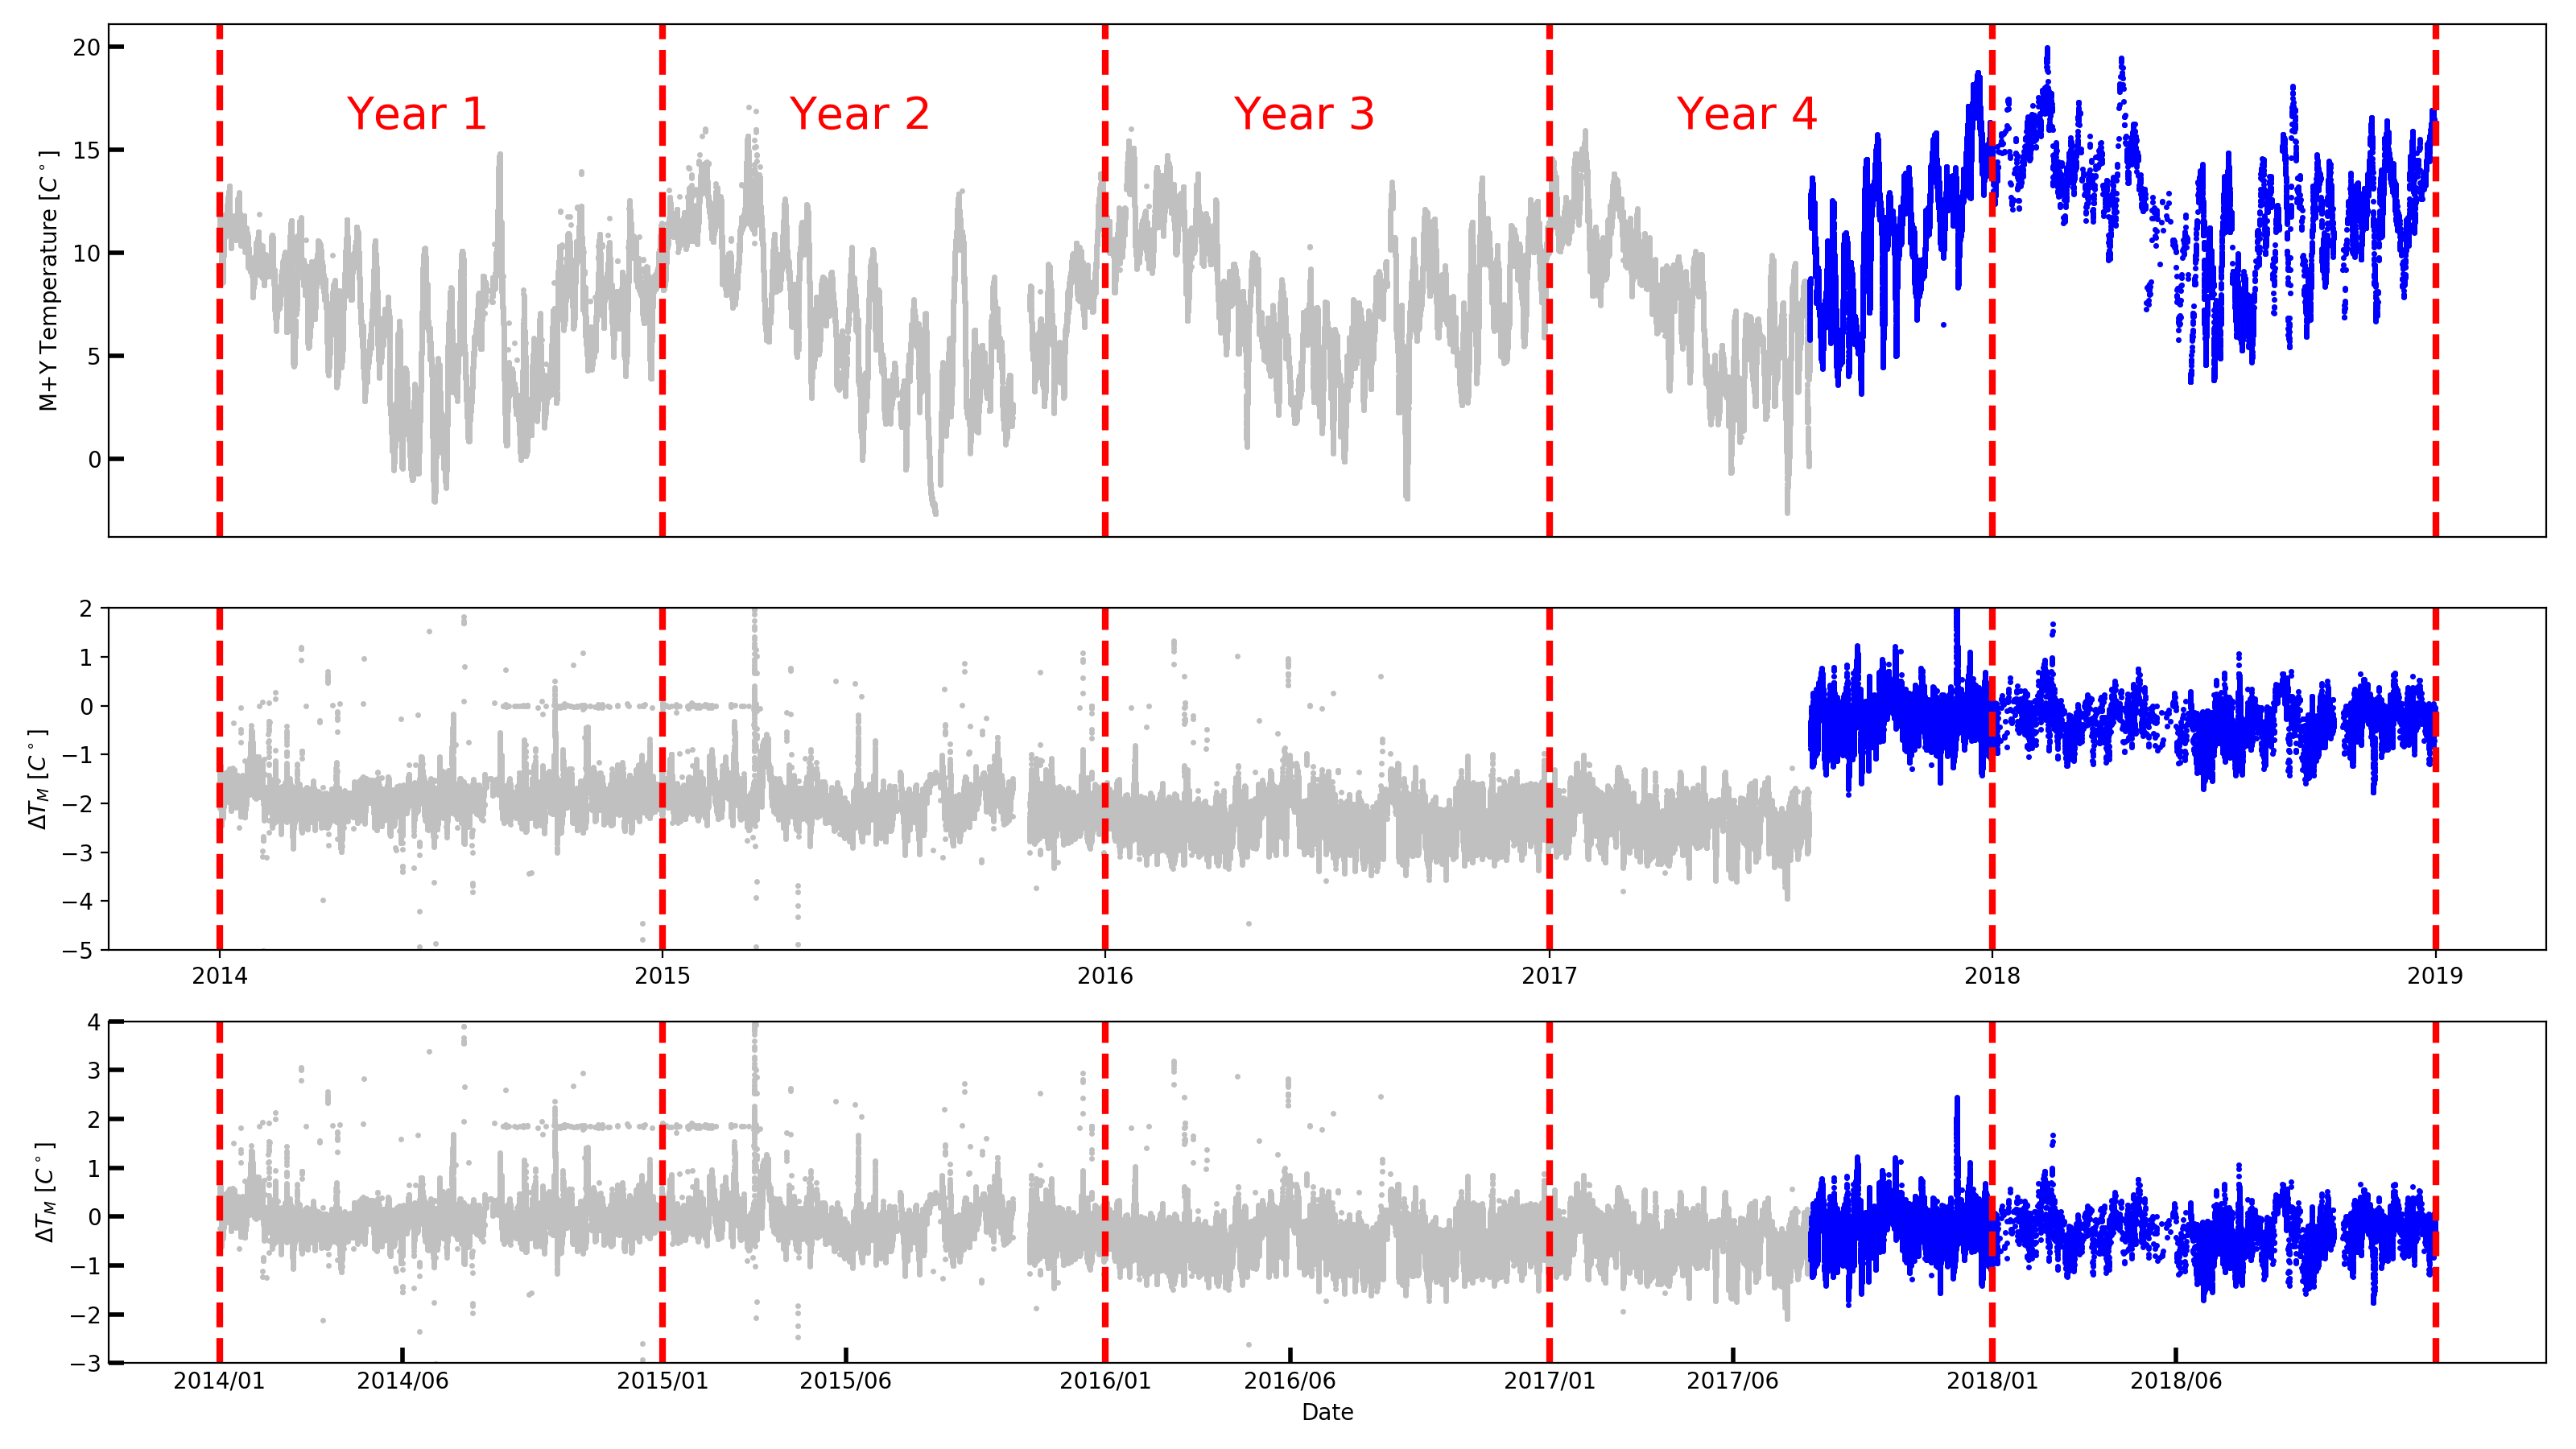

In [6]:
%matplotlib notebook

date = datetime.date(year = 2017, month = 8, day =3)

#  AO system requirements
cond1 = (env_data['dts'] > date) 
ind = np.where(cond1)[0]

cond2 = (env_data['dts'] < date) 
ind2 = np.where(cond2)[0]

af = cp.iloc[ind]
bf = cp.iloc[ind2]

#cp.loc[ind,'T_M1+Y'] = env_data.loc[ind,'T_M1+Y'] + 4.16
#cp.loc[ind,'T_M1-Y'] = env_data.loc[ind,'T_M1-Y'] + 2.31

fig = plt.figure(figsize=[16,9])
gs = gridspec.GridSpec(3, 1, height_ratios=[3,2,2]) 

#fig, (ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=[12,6])

ax1 = plt.subplot(gs[0])
ax1.plot(cp['dts'],cp['T_M1+Y'],'.',markersize = 3,color='silver')
ax1.plot(af['dts'],af['T_M1+Y'],'.',markersize = 3,color='b')

#ax1.legend(['Before','After'],loc=3,facecolor='white',markerscale=6,frameon=False)

ax1.axvline(x=datetime.date(month=1,year = 2014, day =1),color = 'r',linewidth = 3,linestyle='--')
ax1.axvline(x=datetime.date(month=1,year = 2015, day =1),color = 'r',linewidth = 3,linestyle='--')
ax1.axvline(x=datetime.date(month=1,year = 2016, day =1),color = 'r',linewidth = 3,linestyle='--')
ax1.axvline(x=datetime.date(month=1,year = 2017, day =1),color = 'r',linewidth = 3,linestyle='--')
ax1.axvline(x=datetime.date(month=1,year = 2018, day =1),color = 'r',linewidth = 3,linestyle='--')
ax1.axvline(x=datetime.date(month=1,year = 2019, day =1),color = 'r',linewidth = 3,linestyle='--')



ax1.annotate('Year 1',[datetime.date(month=4,year = 2014, day =15),16],fontsize =20,color = 'r')
ax1.annotate('Year 2',[datetime.date(month=4,year = 2015, day =15),16],fontsize =20,color = 'r')
ax1.annotate('Year 3',[datetime.date(month=4,year = 2016, day =15),16],fontsize =20,color = 'r')
ax1.annotate('Year 4',[datetime.date(month=4,year = 2017, day =15),16],fontsize =20,color = 'r')
ax1.annotate('Year 5',[datetime.date(month=4,year = 2019, day =15),16],fontsize =20,color = 'r')



ax1.tick_params(axis='both',which = 'both',direction='in', width=2,length = 7, bottom = False, top=True,)
ax1.set_xticks([])
#ax1.set_xticks()
            
ax1.set_ylabel('M+Y Temperature [$C^\circ$]')

ax2 = plt.subplot(gs[1])
ax2.plot(cp['dts'],cp['T_M1+Y']-cp['T_M1-Y'],'.',markersize = 3,color='silver')
ax2.plot(af['dts'],af['T_M1+Y']-af['T_M1-Y'],'.',markersize = 3,color='b')

ax2.axvline(x=datetime.date(month=1,year = 2014, day =1),color = 'r',linewidth = 3,linestyle='--')
ax2.axvline(x=datetime.date(month=1,year = 2015, day =1),color = 'r',linewidth = 3,linestyle='--')
ax2.axvline(x=datetime.date(month=1,year = 2016, day =1),color = 'r',linewidth = 3,linestyle='--')
ax2.axvline(x=datetime.date(month=1,year = 2017, day =1),color = 'r',linewidth = 3,linestyle='--')
ax2.axvline(x=datetime.date(month=1,year = 2018, day =1),color = 'r',linewidth = 3,linestyle='--')
ax2.axvline(x=datetime.date(month=1,year = 2019, day =1),color = 'r',linewidth = 3,linestyle='--')



ax2.set_ylim(-5,2)
ax2.set_ylabel(r'$\Delta{T}_{M}$ [$C^\circ$]')

ax3 = plt.subplot(gs[2])
ax3.plot(bf.loc[ind2,'dts'],(bf.loc[ind2,'T_M1+Y'] + 4.16) - (bf.loc[ind2,'T_M1-Y'] + 2.31),'.',markersize = 3,color='silver')
ax3.plot(af['dts'],af['T_M1+Y']-af['T_M1-Y'],'.',markersize = 3,color='b')

ax3.axvline(x=datetime.date(month=1,year = 2014, day =1),color = 'r',linewidth = 3,linestyle='--')
ax3.axvline(x=datetime.date(month=1,year = 2015, day =1),color = 'r',linewidth = 3,linestyle='--')
ax3.axvline(x=datetime.date(month=1,year = 2016, day =1),color = 'r',linewidth = 3,linestyle='--')
ax3.axvline(x=datetime.date(month=1,year = 2017, day =1),color = 'r',linewidth = 3,linestyle='--')
ax3.axvline(x=datetime.date(month=1,year = 2018, day =1),color = 'r',linewidth = 3,linestyle='--')
ax3.axvline(x=datetime.date(month=1,year = 2019, day =1),color = 'r',linewidth = 3,linestyle='--')



ax3.tick_params(axis='both',which = 'both',direction='in', width=2,length = 7)
ax3.set_xticks([datetime.date(month=1,year = 2014, day =1),
            datetime.date(month=1,year = 2015, day =1),
            datetime.date(month=1,year = 2016, day =1),
            datetime.date(month=1,year = 2017, day =1),
            datetime.date(month=1,year = 2018, day =1),
            datetime.date(month=6,year = 2014, day =1),
            datetime.date(month=6,year = 2015, day =1),
            datetime.date(month=6,year = 2016, day =1),
            datetime.date(month=6,year = 2017, day =1),
            datetime.date(month=6,year = 2018, day =1)])


yearsFmt = mdates.DateFormatter('%Y/%m')
ax3.xaxis.set_major_formatter(yearsFmt)
ax3.set_ylim(-3,4)
ax3.set_xlabel('Date')
ax3.set_ylabel(r'$\Delta{T}_{M}$ [$C^\circ$]')
plt.tight_layout()

#plt.savefig('/Users/melisatallis/Dropbox (GPI)/TEST_SCRATCH/scratch/mtallis/plots/SPIE_poster_figs/calibration_proc.png')


Show fit of bc data on af data 

One year at a time in between steps

In [44]:
date = datetime.date(year = 2017, month = 8, day =2)
ind1 = np.where(env_data['dts'] <= date)[0]
ind2 = np.where(env_data['dts'] > date)[0]

bf = cp.iloc[ind1].sort_values(by='dts').set_index(np.arange(len(ind1)))
af = cp.iloc[ind2].sort_values(by = 'dts').set_index(np.arange(len(ind2)))
    
#  Replace year of dts to 2000
bf.loc[:,'dts'] = bf['dts'].apply(lambda dt: dt.replace(year = 2000 )) 
bf.loc[:,'MJDOBS'] = aptime.Time(bf['dts'].dt.to_pydatetime(), format='datetime').mjd  # Calculate MJD date after changing year 
bf = bf.sort_values(by ='dts').set_index(np.arange(len(bf))).dropna(subset=[sensor])  #  Sort the values in order by date

af.loc[:,'dts'] = af['dts'].apply(lambda dt: dt.replace(year = 2000 ))
af.loc[:,'MJDOBS'] = aptime.Time(af['dts'].dt.to_pydatetime(), format='datetime').mjd
af = af.sort_values(by ='dts').set_index(np.arange(len(af))).dropna(subset=[sensor])

IndexError: positional indexers are out-of-bounds

All years combined steps

In [11]:
#  Split data into before and after calibration data frames. 
date = datetime.date(year = 2017, month = 8, day =2)
ind1 = np.where(env_data['dts'] <= date)[0]
ind2 = np.where(env_data['dts'] > date)[0]

bf = env_data.iloc[ind1].sort_values(by='dts').set_index(np.arange(len(ind1)))
af = env_data.iloc[ind2].sort_values(by = 'dts').set_index(np.arange(len(ind2)))
    
bf_date1 = datetime.datetime(year = yr, month = 8, day =2) # lower bound of data beofre calibration
bf_date2 = datetime.datetime(year = yr, month = 12, day = 31)

cond1 = bf['dts'] > bf_date1
cond2  = bf['dts'] <= bf_date2
bf_ind = np.where(cond1 & cond2)[0]
        
# pick points that overlap with af dates
bf = bf.iloc[bf_ind].sort_values(by='dts').set_index(np.arange(len(bf_ind))).dropna(subset=[sensor])
    
#  Replace year of after to coincide with year of before
af.loc[:,'dts'] = af['dts'].apply(lambda dt: dt.replace(year = yr))
af.loc[:,'MJDOBS'] = aptime.Time(af['dts'].dt.to_pydatetime(), format='datetime').mjd
af = af.sort_values(by ='dts').set_index(np.arange(len(af))).dropna(subset=[sensor])

NameError: name 'yr' is not defined

In [12]:
%matplotlib notebook

plt.figure(1,figsize = [12,8])
plt.plot(bf['MJDOBS'],bf['T_M1+Y'],'.',markersize=2,color ='silver')
plt.plot(af['MJDOBS'],af['T_M1+Y'],'.',markersize=2,color='b')

def func(x, a, b):
    return a*x + b
    
date = datetime.date(year = 2000, month = 8, day =2)

#  Input arrays for curve fit
x = bf.loc[ind,'MJDOBS']
y = bf.loc[ind,sensor]
     
#  model calibration model
popt,pcov = optimize.curve_fit(func,x,y)

plt.plot(x,func(x))

#yearsFmt = mdates.DateFormatter('%Y/%m')
#plt.xaxis.set_major_formatter(yearsFmt)

plt.ylabel('Temperature [C]')
plt.xlabel('Date')
plt.xticks(rotation = 20)

#plt.savefig(savedir+'bf_cal'+dstr+'.png',dpi = 300)

<IPython.core.display.Javascript object>

KeyError: 'None of [[285262 285263 285264 ..., 330423 330424 330425]] are in the [index]'

In [66]:
savedir = os.environ["HOME"]+'/Dropbox (GPI)/TEST_SCRATCH/scratch/mtallis/plots/calibration/'
dstr = time.strftime('%Y%m%d')